# **UDACITY DATA ENGINEERING CAPSTONE PROJECT**
## **`BIKE SHARE AND TEMPERATURE IN CHICAGO`**

### **Project Summary**
This project aims to build up a data warehouse by integrating Divvy bike trip and temperature data together to provide a **`one-stop-shopping`** for OLAP and BI app to do analysis with these data sources. After lauching the data warehouse successfully, some data visualization and analysis will be done in order to get insight from the data.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
import pandas as pd
import glob
import numpy as np
import os
import configparser
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from helper.quality_check import QualityCheck, sql_queries
from io import StringIO
from collections import OrderedDict

## **Step 1: Scope the Project and Gather Data**
### **Project Scope** 
#### **Objective**
This project will integrate Divvy bike trip and Chicago temperature data in 2021 to setup a data warehouse with fact and dimension tables. From the data warehouse, we can easily answer some interesting business question:
- How does the number of bike trips change in 2021 by monthly, daily, or hourly?
- How does the average using time on each bike trip change in 2021 by monthly, daily or hourly?
- Which station has the largest traffic during 2021?
- What range of temperature does people in Chicago like to use bike the most?
- How does the temperature effect the average using time on each bike trip?

These answers can help Divvy bike share company know where and when they should increase the number of bikes to meet the demand, as well as the most favourite bike types in Chicago. In addition, insight from the effect of temperature can make the company understand more deeply about the customer behaviour.
#### **Tool**
- **`Python`** for doing ETL
    - Pandas
    - Numpy
- **`PostgresSQL`** for data warehousing
- **`Python`** for data visualization and analysis
    - Matplotlib
    - Seaborn
### **Describe and Gather Data** 
#### **Data sources**
- **`Bike trip data`** - Dataset contains information about all information about bike trip in Chicago 2021. The dataset comes from [Kaggle](https://www.kaggle.com/) and contains about **5.5 million** lines of data in **csv** format. 
- **`Temperature data`** - Dataset contains information about daily temperature in Chicago in 2021. The dataset comes from [Weather](https://www.weather.gov/) and contains **365** lines of data in **xlsx** format, represents for 365 days in 2021.

In [2]:
# function to get paths of the data
get_data_paths = lambda folder_path, file_type: glob.glob(os.path.join(folder_path, '*.' + file_type))

In [3]:
trip_data_paths = get_data_paths(folder_path='data/bike_trip', file_type='csv')
trip_data_paths

['data/bike_trip\\202101-divvy-tripdata.csv',
 'data/bike_trip\\202102-divvy-tripdata.csv',
 'data/bike_trip\\202103-divvy-tripdata-1.csv',
 'data/bike_trip\\202103-divvy-tripdata-2.csv',
 'data/bike_trip\\202103-divvy-tripdata-3.csv',
 'data/bike_trip\\202103-divvy-tripdata-4.csv',
 'data/bike_trip\\202103-divvy-tripdata-5.csv',
 'data/bike_trip\\202103-divvy-tripdata-6.csv',
 'data/bike_trip\\202103-divvy-tripdata-7.csv',
 'data/bike_trip\\202104-divvy-tripdata-1.csv',
 'data/bike_trip\\202104-divvy-tripdata-2.csv',
 'data/bike_trip\\202104-divvy-tripdata-3.csv',
 'data/bike_trip\\202104-divvy-tripdata-4.csv',
 'data/bike_trip\\202104-divvy-tripdata-5.csv',
 'data/bike_trip\\202104-divvy-tripdata-6.csv',
 'data/bike_trip\\202104-divvy-tripdata-7.csv',
 'data/bike_trip\\202105-divvy-tripdata-1.csv',
 'data/bike_trip\\202105-divvy-tripdata-2.csv',
 'data/bike_trip\\202105-divvy-tripdata-3.csv',
 'data/bike_trip\\202105-divvy-tripdata-4.csv',
 'data/bike_trip\\202105-divvy-tripdata-5.cs

In [4]:
# Combine all bike trip data into 1 dataframe
trip_df = pd.concat((pd.read_csv(path) for path in trip_data_paths), ignore_index=True)
trip_df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,E19E6F1B8D4C42ED,electric_bike,2021-01-23 16:14:19,2021-01-23 16:24:44,California Ave & Cortez St,17660,NaN,NaN,41.900341,-87.696743,41.89,-87.72,member
1,DC88F20C2C55F27F,electric_bike,2021-01-27 18:43:08,2021-01-27 18:47:12,California Ave & Cortez St,17660,NaN,NaN,41.900333,-87.696707,41.90,-87.69,member
2,EC45C94683FE3F27,electric_bike,2021-01-21 22:35:54,2021-01-21 22:37:14,California Ave & Cortez St,17660,NaN,NaN,41.900313,-87.696643,41.90,-87.70,member
3,4FA453A75AE377DB,electric_bike,2021-01-07 13:31:13,2021-01-07 13:42:55,California Ave & Cortez St,17660,NaN,NaN,41.900399,-87.696662,41.92,-87.69,member
4,BE5E8EB4E7263A0B,electric_bike,2021-01-23 02:24:02,2021-01-23 02:24:45,California Ave & Cortez St,17660,NaN,NaN,41.900326,-87.696697,41.90,-87.70,casual


In [5]:
temp_data_paths = get_data_paths(folder_path='data/temperature', file_type='xlsx')
temp_data_paths

['data/temperature\\temp_data_2021_01.xlsx',
 'data/temperature\\temp_data_2021_02.xlsx',
 'data/temperature\\temp_data_2021_03.xlsx',
 'data/temperature\\temp_data_2021_04.xlsx',
 'data/temperature\\temp_data_2021_05.xlsx',
 'data/temperature\\temp_data_2021_06.xlsx',
 'data/temperature\\temp_data_2021_07.xlsx',
 'data/temperature\\temp_data_2021_08.xlsx',
 'data/temperature\\temp_data_2021_09.xlsx',
 'data/temperature\\temp_data_2021_10.xlsx',
 'data/temperature\\temp_data_2021_11.xlsx',
 'data/temperature\\temp_data_2021_12.xlsx']

In [6]:
# Combine all temperature trip data into 1 dataframe
temp_df = pd.concat((pd.read_excel(path, index_col=None) for path in temp_data_paths), ignore_index=True)
temp_df.head(10)

,date,max_temp,min_temp,average_temp
0,2021-01-01,35,19,27.0
1,2021-01-02,35,28,31.5
2,2021-01-03,33,26,29.5
3,2021-01-04,30,24,27.0
4,2021-01-05,37,29,33.0
5,2021-01-06,39,31,35.0
6,2021-01-07,38,33,35.5
7,2021-01-08,36,30,33.0
8,2021-01-09,37,28,32.5
9,2021-01-10,29,24,26.5


In [7]:
trip_df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [8]:
# Shape of trip dataframe
trip_df.shape

(5595063, 13)

In [9]:
temp_df.dtypes

date            datetime64[ns]
max_temp                 int64
min_temp                 int64
average_temp           float64
dtype: object

In [10]:
# Shape of temperature dataframe
temp_df.shape

(365, 4)

## **Step 2: Explore and Assess the Data**
In order to track the progress easily, this project works on two steps (`exploring` the problem and `cleaning` the data) simultanously. 
### **Explore the Data** 
Identify data quality issues likes:
- Null values
- Inaproppriate data types and time data
- Duplicates data
### **Cleaning steps**
- Eliminate Null or NaN values
- Covert data type of columns 
- Eliminate values not in the time period (just in `2021`)
- Eliminate records that don't have the same start and end date
- Divide the raw dataframe into relevant dataframes following Star Schema method

#### **`Process null values`**

##### **Trip data**

In [11]:
trip_df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    690809
start_station_id      690806
end_station_name      739170
end_station_id        739170
start_lat                  0
start_lng                  0
end_lat                 4771
end_lng                 4771
member_casual              0
dtype: int64

- As we can see, there is a lot of null values in station columns. We can dropped this null values to make the data more reliable.

In [12]:
trip_df.dropna(inplace=True)
trip_df.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

In [13]:
# Size of trip data after eliminating null values
trip_df.shape

(4588302, 13)

##### **Temperature data**

In [14]:
temp_df.isnull().sum()

date            0
max_temp        0
min_temp        0
average_temp    0
dtype: int64

#### **`Change datatypes`**

In [15]:
trip_df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

- From the result above, it's easy to regconize that the time columns (`started_at` and `ended_at`) are still in type of string. So we change the type of these columns into datetime object. The datetime datatypes allow us to extract the time data from these columns.

In [16]:
trip_df[['started_at', 'ended_at']] = trip_df[['started_at', 'ended_at']].apply(pd.to_datetime)
trip_df.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

#### **`Eliminate values not in time period`** 

- Because the scope of this project is building a data warehouse for data in 2021. So we have to eliminate the records occuring before or after the year 2021.

##### **Check whether any values are before 2021**

In [17]:
pd.Series(trip_df['started_at'].dt.year < 2021).value_counts()

False    4588302
Name: started_at, dtype: int64

In [18]:
pd.Series(trip_df['ended_at'].dt.year < 2021).value_counts()

False    4588302
Name: ended_at, dtype: int64

- There aren't any values before 2021 in our data.

##### **Check whether any values are after 2021**

In [19]:
pd.Series(trip_df['started_at'].dt.year > 2021).value_counts()

False    4588302
Name: started_at, dtype: int64

In [20]:
pd.Series(trip_df['ended_at'].dt.year > 2021).value_counts()

False    4588248
True          54
Name: ended_at, dtype: int64

- There are 54 values occurred after the year 2021. So we rule out these values.

##### **Eliminate the inappropriate values in **`ended_at`** columnn**

In [21]:
trip_df = trip_df[trip_df['ended_at'].dt.year < 2022]

In [22]:
trip_df.shape

(4588248, 13)

#### **`Eliminate bike trip didn't start and end on the same date`**

- As the temperature dataset just contains the daily temperature. So we just need the trip started and ended in the same date, in order to fit with the temperature data.

##### **Check whether any rides didn't start and end in the same date**

In [23]:
pd.Series(trip_df['started_at'].dt.normalize() == trip_df['ended_at'].dt.normalize()).value_counts()

True     4555485
False      32763
dtype: int64

- As we can see from the result above, there are `32763` rides that didn't start and end in the same date.

##### **Eliminate rides didn't start and end on the same date**

In [24]:
trip_df = trip_df[trip_df['started_at'].dt.normalize() == trip_df['ended_at'].dt.normalize()]
pd.Series(trip_df['started_at'].dt.normalize() == trip_df['ended_at'].dt.normalize()).value_counts()

True    4555485
dtype: int64

## **Step 3: Define the Data Model**
### **3.1 Conceptual Data Model**
For the purpose of this data warehouse is provide one-stop-shopping place for OLAP and BI apps, we use Star schema to model our data. There are 1 fact table and 4 dimension tables as image below.
<p align="center">
    <img src="./image/data_model.png" width="50%">
</p>

#### `Fact table`
- **fact_trip**: Detail information about the bike trip.
#### `Dimension table`
- **dim_station**: Include information about the station.
- **dim_time**: Include atomic data about the time.
- **dim_bike_type**: Include information about bike type.
- **dim_member_type**: Include information about the member type.

### **3.2 Mapping Out Data Pipelines**
To complete the data pipeline, several steps were taken:
- Divide dataframe into smaller data frames and do transform to adapt the data model
- Using COPY command and StringIO buffer (for the sake of speed) to load data into data warehouse
- Doing data quality check

## **Step 4: Run Pipelines to Model the Data** 
### **4.1 Create the data model**
Build the data pipelines to create the data model.
#### **4.1.1 Divide dataframe and transform to adapt Star Schema data model**
##### **Table dim_station**
- Create **`station`** dataframe

In [25]:
start_station_df = trip_df[['start_station_id', 'start_station_name', 'start_lat', 'start_lng', 'started_at']]
start_station_df = start_station_df.rename(columns={'start_station_id':'station_id', 'start_station_name':'station_name', 
                                                    'start_lat':'station_lat', 'start_lng':'station_lng', 'started_at': 'time'})
end_station_df = trip_df[['end_station_id', 'end_station_name', 'end_lat', 'end_lng', 'ended_at']]
end_station_df = end_station_df.rename(columns={'end_station_id':'station_id', 'end_station_name':'station_name', 
                                                'end_lat':'station_lat', 'end_lng':'station_lng', 'ended_at': 'time'})

station_df = pd.concat((start_station_df, end_station_df), ignore_index=True).sort_values(by=['time'], ascending=True)
station_df.shape

(9110970, 5)

- Address the change of **`station`** names in **`station_id`**

    - In this session, there are some `station_id` having changes in name over time. We can use `Slowly Changing Dimemsion (SCD)` to deal with this situation. But in order to simplify, we just keep the lastest name of each station in this project. The `SCD` will be applied after further study on how to use `SCD`. 

In [26]:
station_df = station_df.drop_duplicates(subset=['station_id'], keep='last').drop(columns=['time'])
station_df.shape

(832, 4)

In [27]:
station_df.head(5)

,station_id,station_name,station_lat,station_lng
234898,20248.0,N Hampden Ct & W Diversey Ave,41.930000,-87.64000
4884360,20258.0,N Damen Ave & W Wabansia St,41.910000,-87.68000
1385803,20999,Lyft Driver Center Private Rack,41.900000,-87.66000
1812101,DIVVY CASSETTE REPAIR MOBILE STATION,DIVVY CASSETTE REPAIR MOBILE STATION,41.881039,-87.61673
8144164,20126,S Aberdeen St & W 106th St,41.700000,-87.65000


##### **Table dim_bike_type**
- Create **`bike_type`** dataframe

In [28]:
bike_type_data = [bike_type for bike_type in trip_df['rideable_type'].unique()]
bike_type_df = pd.DataFrame({'bike_type_id': list(range(1, len(bike_type_data) + 1)), 
                            'bike_type': bike_type_data})
bike_type_df

,bike_type_id,bike_type
0,1,classic_bike
1,2,electric_bike
2,3,docked_bike


##### **Table dim_time**
- Create **`time`** dataframe

In [29]:
time_extract_func = lambda x: [x, x.year, x.month, x.day, x.day_name(), x.hour]
time_data = trip_df['started_at'].append(trip_df['ended_at']).drop_duplicates()
time_extract = list(map(time_extract_func, time_data))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8472\625595988.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_data = trip_df['started_at'].append(trip_df['ended_at']).drop_duplicates()


In [30]:
time_cols = ['time', 'year', 'month', 'date', 'weekday', 'hour']
time_df = pd.DataFrame(time_extract, columns=time_cols)
time_df.head(10)

,time,year,month,date,weekday,hour
0,2021-01-24 19:15:38,2021,1,24,Sunday,19
1,2021-01-23 12:57:38,2021,1,23,Saturday,12
2,2021-01-09 15:28:04,2021,1,9,Saturday,15
3,2021-01-09 15:28:57,2021,1,9,Saturday,15
4,2021-01-24 15:56:59,2021,1,24,Sunday,15
5,2021-01-22 15:15:28,2021,1,22,Friday,15
6,2021-01-05 10:33:12,2021,1,5,Tuesday,10
7,2021-01-30 11:59:16,2021,1,30,Saturday,11
8,2021-01-27 07:27:09,2021,1,27,Wednesday,7
9,2021-01-15 08:54:41,2021,1,15,Friday,8


##### **Table dim_member_type**
- Create **`member_type`** dataframe

In [31]:
member_type_data = [member_type for member_type in trip_df['member_casual'].unique()]
member_type_df = pd.DataFrame({'member_type_id': list(range(1, len(member_type_data) + 1)),
                        'member_type': member_type_data})
member_type_df

,member_type_id,member_type
0,1,member
1,2,casual


##### **Table fact_trip table**
- Drop unrelevant columns

In [32]:
trip_df = trip_df.drop(['start_station_name', 'end_station_name', 
                        'start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1)

- Add temperature data into trip data

In [33]:
trip_df['trip_date'] = trip_df['started_at'].dt.normalize()
trip_df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_id,end_station_id,member_casual,trip_date
9,B9F73448DFBE0D45,classic_bike,2021-01-24 19:15:38,2021-01-24 19:22:51,17660,657,member,2021-01-24
10,457C7F4B5D3DA135,electric_bike,2021-01-23 12:57:38,2021-01-23 13:02:10,17660,13258,member,2021-01-23
11,57C750326F9FDABE,electric_bike,2021-01-09 15:28:04,2021-01-09 15:37:51,17660,657,casual,2021-01-09
12,4D518C65E338D070,electric_bike,2021-01-09 15:28:57,2021-01-09 15:37:54,17660,657,casual,2021-01-09
13,9D08A3AFF410474D,classic_bike,2021-01-24 15:56:59,2021-01-24 16:07:08,17660,657,casual,2021-01-24


In [34]:
trip_df = pd.merge(trip_df, temp_df, left_on='trip_date', right_on='date', how='inner').drop(['trip_date', 'max_temp', 
                                                                                                'min_temp', 'date'], axis=1)
trip_df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_id,end_station_id,member_casual,average_temp
0,B9F73448DFBE0D45,classic_bike,2021-01-24 19:15:38,2021-01-24 19:22:51,17660,657,member,30.5
1,9D08A3AFF410474D,classic_bike,2021-01-24 15:56:59,2021-01-24 16:07:08,17660,657,casual,30.5
2,43DB7DCE2339EC6D,classic_bike,2021-01-24 13:45:19,2021-01-24 14:14:38,17660,TA1309000058,member,30.5
3,566DC7E87184417D,classic_bike,2021-01-24 10:11:38,2021-01-24 10:22:01,15623,TA1309000066,member,30.5
4,230BD5A777C9CB90,classic_bike,2021-01-24 15:09:35,2021-01-24 15:14:39,TA1307000038,TA1308000049,member,30.5


- Add trip duration into trip dataframe

In [35]:
trip_df['duration'] = (trip_df['ended_at'] - trip_df['started_at']).astype('timedelta64[m]')
trip_df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_id,end_station_id,member_casual,average_temp,duration
0,B9F73448DFBE0D45,classic_bike,2021-01-24 19:15:38,2021-01-24 19:22:51,17660,657,member,30.5,7.0
1,9D08A3AFF410474D,classic_bike,2021-01-24 15:56:59,2021-01-24 16:07:08,17660,657,casual,30.5,10.0
2,43DB7DCE2339EC6D,classic_bike,2021-01-24 13:45:19,2021-01-24 14:14:38,17660,TA1309000058,member,30.5,29.0
3,566DC7E87184417D,classic_bike,2021-01-24 10:11:38,2021-01-24 10:22:01,15623,TA1309000066,member,30.5,10.0
4,230BD5A777C9CB90,classic_bike,2021-01-24 15:09:35,2021-01-24 15:14:39,TA1307000038,TA1308000049,member,30.5,5.0


- Join bike_type key into trip data

In [36]:
trip_df = pd.merge(trip_df, bike_type_df, left_on='rideable_type', right_on='bike_type', how='inner') \
            .drop(['rideable_type', 'bike_type'], axis=1)

- Join member_type key into trip data

In [37]:
trip_df = pd.merge(trip_df, member_type_df, left_on='member_casual', right_on='member_type', how='inner') \
            .drop(['member_casual', 'member_type'], axis=1)

In [38]:
# The complete dataframe for fact_trip table
trip_df.head(5)

,ride_id,started_at,ended_at,start_station_id,end_station_id,average_temp,duration,bike_type_id,member_type_id
0,B9F73448DFBE0D45,2021-01-24 19:15:38,2021-01-24 19:22:51,17660,657,30.5,7.0,1,1
1,43DB7DCE2339EC6D,2021-01-24 13:45:19,2021-01-24 14:14:38,17660,TA1309000058,30.5,29.0,1,1
2,566DC7E87184417D,2021-01-24 10:11:38,2021-01-24 10:22:01,15623,TA1309000066,30.5,10.0,1,1
3,230BD5A777C9CB90,2021-01-24 15:09:35,2021-01-24 15:14:39,TA1307000038,TA1308000049,30.5,5.0,1,1
4,28CE185B7EDFFA59,2021-01-24 17:28:33,2021-01-24 17:33:49,KA1503000044,KA1503000012,30.5,5.0,1,1


#### **4.1.2 Load data into data warehouse**

##### **Connect to data warehouse hosted in Postgres**

In [39]:
config = configparser.ConfigParser()
config.read('db_credentials.cfg')
conn = psycopg2.connect(host=config['POSTGRES']['host'], user=config['POSTGRES']['user'], password=config['POSTGRES']['password'], 
                        database=config['POSTGRES']['default_db'])
conn.set_session(autocommit=True)
cur = conn.cursor()

##### **Create database for data warehouse**

In [40]:
# create trip_dwh database with UTF8 encoding
cur.execute(f"DROP DATABASE IF EXISTS {config['DWH']['name']}")
cur.execute(f"CREATE DATABASE {config['DWH']['name']} WITH ENCODING 'utf8' TEMPLATE template0")

# close connection to default database
conn.close()    
    
# connect to trip_dwh database
conn = psycopg2.connect(host=config['POSTGRES']['host'], user=config['POSTGRES']['user'], password=config['POSTGRES']['password'],
                        database=config['DWH']['name'])
conn.set_session(autocommit=True)
cur = conn.cursor()

##### **Create tables for data warehouse**

In [41]:
for create_querry in sql_queries.create_table_sql:
    cur.execute(create_querry)

##### **Load data into data warehouse**

In [42]:
table_data_dict = OrderedDict({'dim_station': station_df, 'dim_bike_type': bike_type_df, 'dim_time': time_df, 
                    'dim_member_type': member_type_df, 'fact_trip': trip_df})

In [43]:
for table, data in table_data_dict.items():
    buffer = StringIO()
    data.to_csv(buffer, header=False, index=False)
    buffer.seek(0)
    cur.copy_from(buffer, table, sep=',')

### **4.2 DATA QUALITY CHECK**

#### **4.2.1 Check integrity of primary key in tables**

In [44]:
table_primary_col = {'fact_trip': 'trip_id', 'dim_station': 'station_id', 'dim_time': 'time', 
                    'dim_bike_type': 'bike_type_id', 'dim_member_type': 'member_type_id'}

for table, primary_col in table_primary_col.items():
    QualityCheck.check_primary_key_integrity(cur, table, primary_col)

Data quality check for primary key of fact_trip table passed.
Data quality check for primary key of dim_station table passed.
Data quality check for primary key of dim_time table passed.
Data quality check for primary key of dim_bike_type table passed.
Data quality check for primary key of dim_member_type table passed.


#### **4.2.2 Check row number in tables**

In [45]:
for table in table_primary_col:
    QualityCheck.check_row_number(cur, table)

Data quality check on row number passed. Table fact_trip contains 4555485 rows.
Data quality check on row number passed. Table dim_station contains 832 rows.
Data quality check on row number passed. Table dim_time contains 6837047 rows.
Data quality check on row number passed. Table dim_bike_type contains 3 rows.
Data quality check on row number passed. Table dim_member_type contains 2 rows.


### **4.3 Data dictionary**
#### **Table fact_trip**
|    **Column**    |                  **Description**                 |
|:----------------:|:------------------------------------------------:|
| trip_id          | Id of the trip                                   |
| start_time       | Start time of the trip                           |
| end_time         | End time of the trip                             |
| start_station_id | Start station of the trip                        |
| end_station_id   | End station of the trip                          |
| temperature      | Temperature of the date when trip took place (F) |
| duration         | Duration of the trip (minutes)                   |
| bike_type_id     | Type of bike used in the trip                    |
| member_type_id   | Customer's member type of the trip               |
#### **Table dim_station**
|  **Column**  |      **Description**     |
|:------------:|:------------------------:|
| station_id   | Id of  the station       |
| station_name | Name of the station      |
| station_lat  | Latitude of the station  |
| station_lng  | Longitude of the station |
#### **Table dim_time**
| **Column** |     **Description**     |
|:----------:|:-----------------------:|
| time       | Time of the trip        |
| year       | Year of the trip        |
| month      | Month of the trip       |
| date       | Date of the trip        |
| weekday    | Day of week of the trip |
| hour       | Hour of the trip        |
#### **Table dim_bike_type**
|  **Column**  | **Description** |
|:------------:|:---------------:|
| bike_type_id | Id of bike type |
| bike_type    | Bike type name  |
#### **Table dim_member_type**
|   **Column**   |  **Description**  |
|:--------------:|:-----------------:|
| member_type_id | Id of member type |
| member_type    | Member type name  |


### **4.4 Data visualization and analysis**
This part does some data visualization and analysis using the data from the data warehouse just created. The business questions are listed in **`project scope`** can be answered using these analysis.

#### **Monthly analysis**

In [46]:
monthly_trip_sqlq = '''
    SELECT month, COUNT(trip_id), AVG(duration) 
    FROM fact_trip
    JOIN dim_time ON fact_trip.start_time = dim_time.time
    GROUP BY month
'''
cur.execute(monthly_trip_sqlq)
monthly_trip_data = cur.fetchall()
monthly_trip_df = pd.DataFrame(data=monthly_trip_data, columns=['month', 'trip_count', 'avg_using_time'])

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Mar'),
 Text(2, 0, 'Feb'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

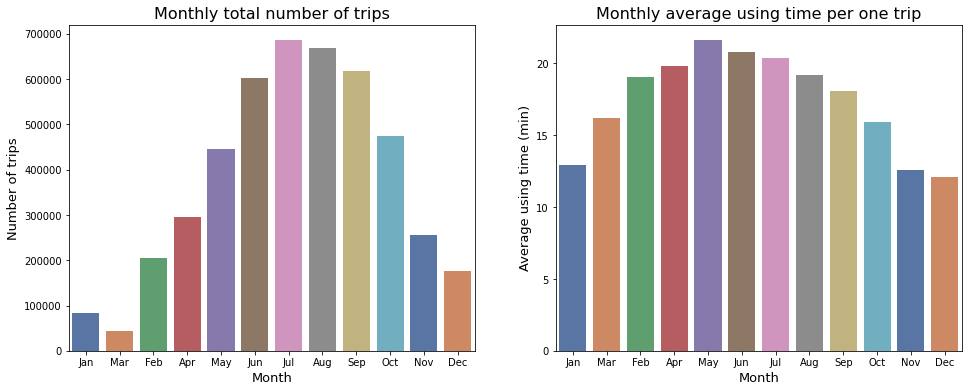

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.barplot(x='month', y='trip_count', data=monthly_trip_df, palette='deep', ax=ax[0])
ax[0].set_title('Monthly total number of trips', fontsize=16)
ax[0].set_xlabel('Month', fontsize=13)
ax[0].set_ylabel('Number of trips', fontsize=13)
ax[0].set_xticklabels(labels=['Jan', 'Mar', 'Feb', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
sns.barplot(x='month', y='avg_using_time', data=monthly_trip_df, palette='deep', ax=ax[1])
ax[1].set_title('Monthly average using time per one trip', fontsize=16)
ax[1].set_xlabel('Month', fontsize=13)
ax[1].set_ylabel('Average using time (min)', fontsize=13)
ax[1].set_xticklabels(labels=['Jan', 'Mar', 'Feb', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

- From the graph, people in Chicago tended to use bike from June to September.
- While in May, the number of trips ranks 6th but having the longest duration of each bike trip

#### **Daily analysis**

In [48]:
daily_trip_sqlq = '''
    SELECT weekday, COUNT(trip_id), AVG(duration) 
    FROM fact_trip
    JOIN dim_time ON fact_trip.start_time = dim_time.time
    GROUP BY weekday
'''
cur.execute(daily_trip_sqlq)
daily_trip_data = cur.fetchall()
daily_trip_df = pd.DataFrame(data=daily_trip_data, columns=['weekday', 'trip_count', 'avg_using_time'])
daily_trip_df['weekday'] = daily_trip_df['weekday'].str[0:3]

Text(0, 0.5, 'Average using time (min)')

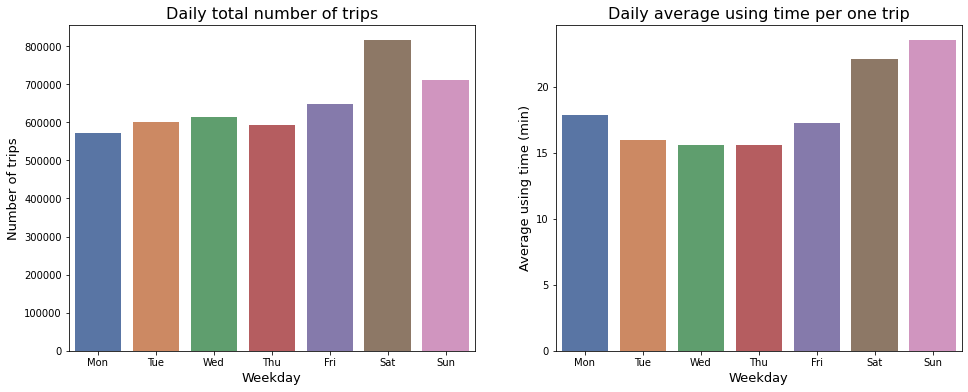

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
col_ord = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x='weekday', y='trip_count', data=daily_trip_df, palette='deep', order=col_ord, ax=ax[0])
ax[0].set_title('Daily total number of trips', fontsize=16)
ax[0].set_xlabel('Weekday', fontsize=13)
ax[0].set_ylabel('Number of trips', fontsize=13)
sns.barplot(x='weekday', y='avg_using_time', data=daily_trip_df, palette='deep', order=col_ord, ax=ax[1])
ax[1].set_title('Daily average using time per one trip', fontsize=16)
ax[1].set_xlabel('Weekday', fontsize=13)
ax[1].set_ylabel('Average using time (min)', fontsize=13)

- As we can see that people used bike as their vehicals more at the weekend, especially on Saturday.
- The average using time per one trip at the weekend is higher than other weekdays.

#### **Hourly analysis**

In [50]:
hourly_trip_sqlq = '''
    SELECT hour, COUNT(trip_id), AVG(duration) 
    FROM fact_trip
    JOIN dim_time ON fact_trip.start_time = dim_time.time
    GROUP BY hour
'''
cur.execute(hourly_trip_sqlq)
hourly_trip_data = cur.fetchall()
hourly_trip_df = pd.DataFrame(data=hourly_trip_data, columns=['hour', 'trip_count', 'avg_using_time'])

Text(0, 0.5, 'Average using time (min)')

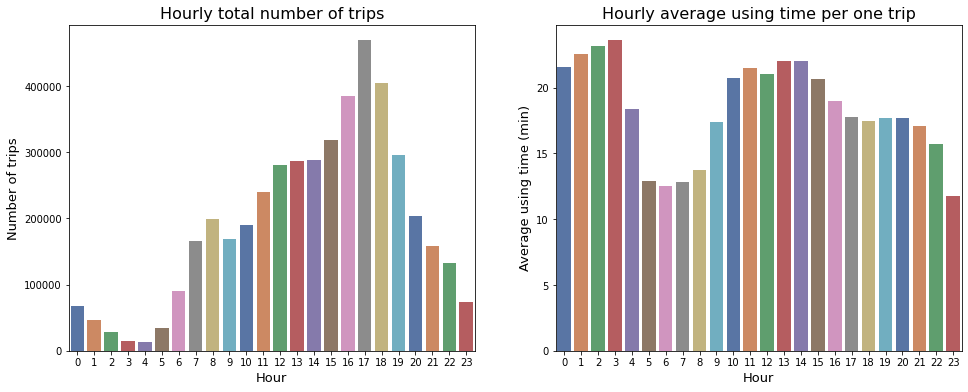

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.barplot(x='hour', y='trip_count', data=hourly_trip_df, palette='deep', ax=ax[0])
ax[0].set_title('Hourly total number of trips', fontsize=16)
ax[0].set_xlabel('Hour', fontsize=13)
ax[0].set_ylabel('Number of trips', fontsize=13)
sns.barplot(x='hour', y='avg_using_time', data=hourly_trip_df, palette='deep', ax=ax[1])
ax[1].set_title('Hourly average using time per one trip', fontsize=16)
ax[1].set_xlabel('Hour', fontsize=13)
ax[1].set_ylabel('Average using time (min)', fontsize=13)

- Rush hours of bicycle use is around the dusk time of the day.
- Whereas, people has longer trip at dawn time and midday.

#### **Member type analysis**

In [52]:
member_sqlq = '''
    SELECT member_type, COUNT(member_type), AVG(duration)
    FROM fact_trip
    JOIN dim_member_type
    ON fact_trip.member_type_id = dim_member_type.member_type_id
    GROUP BY member_type
'''
cur.execute(member_sqlq)
member_analysis_data = cur.fetchall()
member_analysis_df = pd.DataFrame(data=member_analysis_data, columns=['member_type', 'trip_count', 'avg_using_time'])

Text(0, 0.5, 'Average using time (min)')

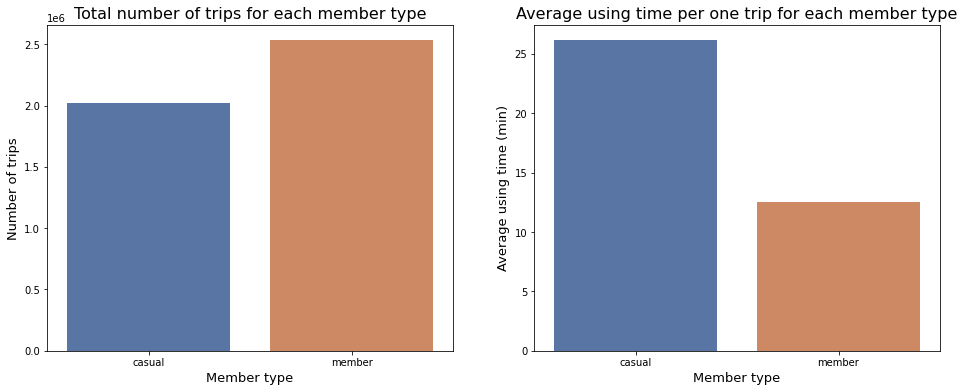

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.barplot(x='member_type', y='trip_count', data=member_analysis_df, palette='deep', ax=ax[0])
ax[0].set_title('Total number of trips for each member type', fontsize=16)
ax[0].set_xlabel('Member type', fontsize=13)
ax[0].set_ylabel('Number of trips', fontsize=13)
sns.barplot(x='member_type', y='avg_using_time', data=member_analysis_df, palette='deep', ax=ax[1])
ax[1].set_title('Average using time per one trip for each member type', fontsize=16)
ax[1].set_xlabel('Member type', fontsize=13)
ax[1].set_ylabel('Average using time (min)', fontsize=13)

- Number of trip taken by casual member is less then normal member, but the trip duration of casual member doubles that of normal member.

#### **Bike type analysis**

In [54]:
bike_sqlq = '''
    SELECT bike_type, COUNT(bike_type), AVG(duration)
    FROM fact_trip
    JOIN dim_bike_type
    ON fact_trip.bike_type_id = dim_bike_type.bike_type_id
    GROUP BY bike_type
'''
cur.execute(bike_sqlq)
bike_analysis_data = cur.fetchall()
bike_analysis_df = pd.DataFrame(data=bike_analysis_data, columns=['bike_type', 'trip_count', 'avg_using_time'])

Text(0, 0.5, 'Average using time (min)')

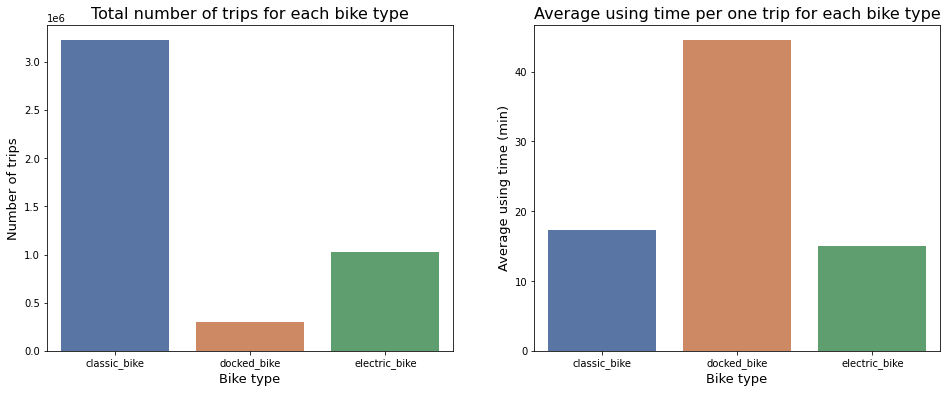

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.barplot(x='bike_type', y='trip_count', data=bike_analysis_df, palette='deep', ax=ax[0])
ax[0].set_title('Total number of trips for each bike type', fontsize=16)
ax[0].set_xlabel('Bike type', fontsize=13)
ax[0].set_ylabel('Number of trips', fontsize=13)
sns.barplot(x='bike_type', y='avg_using_time', data=bike_analysis_df, palette='deep', ax=ax[1])
ax[1].set_title('Average using time per one trip for each bike type', fontsize=16)
ax[1].set_xlabel('Bike type', fontsize=13)
ax[1].set_ylabel('Average using time (min)', fontsize=13)

- Classic bike type has the largest number of uses over 2 others, almost 7 times that of docked bike type. By contrast, docked bike type is the type owned longest average using time per one trip.

#### **Traffic distribution for each station**

In [56]:
station_analysis_sqlq = '''
    SELECT s1.station_lat as start_lat, s1.station_lng as start_lng,  s2.station_lat as end_lat, s2.station_lng as end_lng
    FROM fact_trip t
    JOIN dim_station s1 ON t.start_station_id = s1.station_id
    JOIN dim_station s2 ON t.end_station_id = s2.station_id
'''
cur.execute(station_analysis_sqlq)
station_analysis_data = cur.fetchall()
station_analysis_df = pd.DataFrame(data=station_analysis_data, columns=['start_lat', 'start_lng', 'end_lat', 'end_lng'])
station_analysis_df.head()

,start_lat,start_lng,end_lat,end_lng
0,41.900363,-87.696704,41.899181,-87.672200
1,41.900363,-87.696704,41.924220,-87.646390
2,41.961526,-87.691165,41.969090,-87.674237
3,41.911386,-87.638677,41.906706,-87.635211
4,41.890407,-87.626235,41.886021,-87.630876


Text(0, 0.5, 'Longitude')

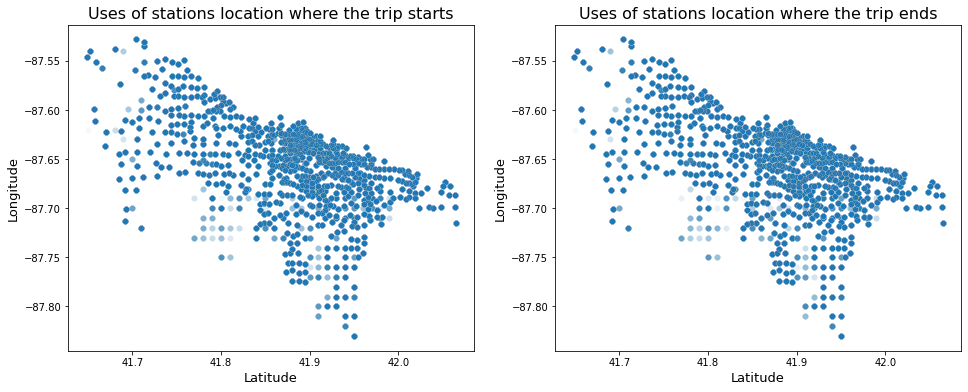

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.scatterplot(x='start_lat', y='start_lng', data=station_analysis_df, alpha=0.05, ax=ax[0])
ax[0].set_title('Uses of station''s location where the trip starts', fontsize=16)
ax[0].set_xlabel('Latitude', fontsize=13)
ax[0].set_ylabel('Longitude', fontsize=13)
sns.scatterplot(x='end_lat', y='end_lng', data=station_analysis_df, alpha=0.05, ax=ax[1])
ax[1].set_title('Uses of station''s location where the trip ends', fontsize=16)
ax[1].set_xlabel('Latitude', fontsize=13)
ax[1].set_ylabel('Longitude', fontsize=13)

#### **Effect of temperature on trip**

In [58]:
temp_trip_sqlq = '''
    SELECT temperature
    FROM fact_trip
'''
cur.execute(temp_trip_sqlq)
temp_trip_data = cur.fetchall()
temp_trip_df = pd.DataFrame(data=temp_trip_data, columns=['temperature'])

temp_using_time_sqlq = '''
    SELECT temperature, AVG(duration)
    FROM fact_trip
    GROUP BY temperature
'''
cur.execute(temp_using_time_sqlq)
temp_using_time_data = cur.fetchall()
temp_using_time_df = pd.DataFrame(data=temp_using_time_data, columns=['temperature', 'avg_using_time'])

Text(0, 0.5, 'Average using time (min)')

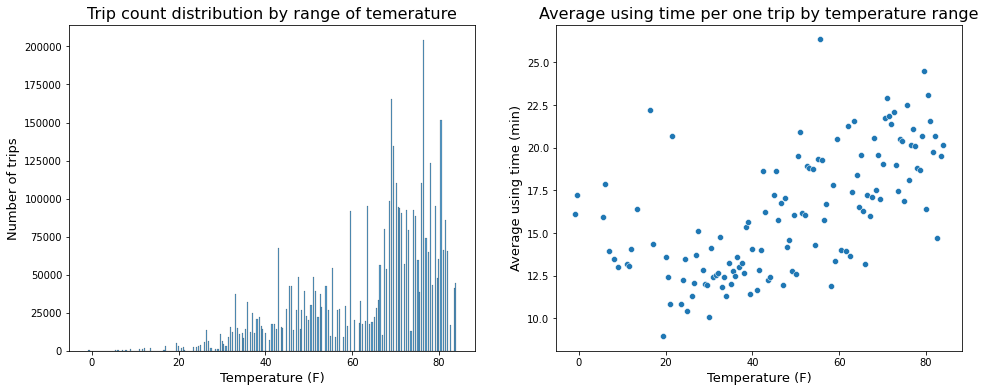

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.histplot(x=temp_trip_df['temperature'], ax=ax[0])
ax[0].set_title('Trip count distribution by range of temerature', fontsize=16)
ax[0].set_xlabel('Temperature (F)', fontsize=13)
ax[0].set_ylabel('Number of trips', fontsize=13)
sns.scatterplot(x='temperature', y='avg_using_time', data=temp_using_time_df, ax=ax[1])
ax[1].set_title('Average using time per one trip by temperature range', fontsize=16)
ax[1].set_xlabel('Temperature (F)', fontsize=13)
ax[1].set_ylabel('Average using time (min)', fontsize=13)

- Number of bike trip rises with the increase of temperature. People likely to use bike in temperature range of 70-80 degrees F. 
- Average using time per one trip also rises with the increase of temperature.

## **Step 5: Complete Project Write Up**
### **Tools and technology**
 - `PostgresSQL` as data warehouse
 - `Python Pandas, Numpy` for cleaning and tranformation
 - `Matplotlib, Seaborn` for visualation

To explain the use of Python and Postgres in this project, our data contains about 5-6 million rows and the analysis in this project isn't too complex so we can use these tools as one of our choice. But the choice of using an OLTP database as data warehouse not always a good idea. With more modern technology today, columnar database like [Redshift](https://aws.amazon.com/redshift/) is much more appropriate for data warehouse, especially when the data warehouse have to scale up - a very common situation nowadays. 
### **Data update frequency**
- The data can be updated monthly or annually depends on the business context of the company. To do the batch ETL, we can use [Airflow](https://airflow.apache.org/), which is a very common and strong tool for orchestration.
- For fact table and big dim tables, because of big size, we should do append-insert pattern for the sake of low cost.
- For small dim tables, we can use truncate-insert to load the data into these tables
### **Other things**
- The data was increased by 100x.
    - In this case, we should use [Spark](https://spark.apache.org/) with distributed cluster to process this amount of data.
    <p align="center">
        <img src="./image/spark_logo.png" width="60%">
    </p>
- The data populates a dashboard that must be updated on a daily basis by 7am every day.
    - We can use [Airflow](https://airflow.apache.org/) or any other orchestration tools to deal with this situation.
    <p align="center">
        <img src="./image/airflow_logo.png" width="60%">
    </p>
- The database needed to be accessed by 100+ people.
    - When the data warehouse scales up like this, we should leverage [Redshift](https://aws.amazon.com/redshift/) to deal with this traffic into data warehouse.
    <p align="center">
        <img src="./image/redshift_logo.png" width="60%">
    </p>